# Homework 2. Свертки и базовые слои

Модули

In [201]:
import random
from copy import deepcopy
import tqdm.notebook as tq
from typing import Optional, Literal

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam

import torchvision
import torchvision.transforms.v2 as v2
from torch.nn.modules.utils import _pair, _quadruple

from PIL import Image, ImageOps

In [2]:
eps = 1e-9

SEED = 161020204
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

numpy_rng = np.random.default_rng(SEED)
torch_rng = torch.Generator().manual_seed(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

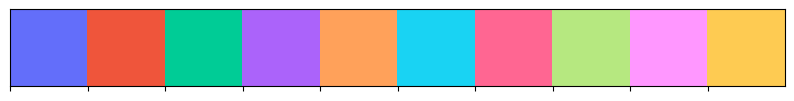

In [3]:
palette = px.colors.qualitative.Plotly

sns.palplot(palette)

---

Пример сетки, на которой будут проверяться новые слои

In [202]:
train_dataset = torchvision.datasets.FashionMNIST(root='./datasets', 
                                           train=True, 
                                           transform=v2.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./datasets', 
                                          train=False, 
                                          transform=v2.ToTensor())

train_dataset.data.size(), train_dataset.targets.size(), type(train_dataset[0][0])

d:\Anaconda\envs\expenv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(torch.Size([60000, 28, 28]), torch.Size([60000]), torch.Tensor)

In [5]:
# # Использовал вместо nn.Flatten()
# class FlattenedDataset(Dataset):
#     def __init__(self, original_dataset):
#         self.original_dataset = original_dataset

#     def __len__(self):
#         return len(self.original_dataset)

#     def __getitem__(self, index):
#         image, label = self.original_dataset[index]
#         image = image.view(-1)
#         return image, label

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

In [10]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

---

## Task 1

Это задание будет являться духовным наследником первого. Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой. На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите). Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя. Однако все элементы, которые вы будете реализовывать, достаточно просты.

**Задача 1. (2 балла):** реализуйте слой BatchNorm (nn.BatchNorm).

**Задача 2. (2 балла):** реализуйте слой Linear (nn.Linear).

**Задача 3. (2 балла):** реализуйте слой Dropout(nn.Dropout)

**Задача 4. (2 балла):** реализуйте одно или более из:

- слой ReLU(nn.ReLU)
- слой Sigmoid(nn.Sigmoid)
- слой Softmax(nn.Softmax)

**Задача 5. (2 балла):** Вы получите по 1 дополнительному баллу за слой, если реализуете в рамках фреймворка из задания 3 прошлой работы.


---

### BatchNorm

In [8]:
class MyBatchNorm1d(nn.Module):

    def __init__(self, 
                 num_features: int, 
                 eps: float = 1e-8, 
                 momentum: float = 0.1
    ) -> None:
        super(MyBatchNorm1d, self).__init__()
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('exp_avg_mean', torch.zeros(num_features))
        self.register_buffer('exp_avg_var', torch.ones(num_features))

    def __call__(self, input: torch.Tensor):
        # forward pass
        if self.training:
            if input.ndim == 2:
                dim = 0
            elif input.ndim == 3:
                dim = (0,1)
            input_mean = input.mean(dim, keepdim=True)
            input_var = input.var(dim, keepdim=True)
        else:
            input_mean = self.exp_avg_mean
            input_var = self.exp_avg_var
        x_hat = (input - input_mean) / torch.sqrt(input_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        # update the buffers (running mean and variance)
        if self.training:
            with torch.no_grad():
                self.exp_avg_mean = (1 - self.momentum) * self.exp_avg_mean + self.momentum * input_mean
                self.exp_avg_var = (1 - self.momentum) * self.exp_avg_var + self.momentum * input_var
        return self.out

### Linear

Реализация nn.Linear в [pytorch](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)

Как работает [_calculate_fan_in_and_fan_out](https://github.com/pytorch/pytorch/blob/4557f6e339e7550b735067296ed479acc02e0487/torch/nn/init.py#L345)

In [9]:
class MyLinear(nn.Module):

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool = True
    ) -> None:
        super(MyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # kaiming normal init for ReLU
        self.weight = nn.Parameter(torch.empty((in_features, out_features)))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        gain = 2 ** 0.5
        torch.nn.init.normal_(self.weight, mean = 0, std = gain / (self.in_features ** 0.5))
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean = 0, std = gain / (self.in_features ** 0.5))

    def __call__(self, input: torch.Tensor):
        self.out = input.matmul(self.weight)
        if self.bias is not None:
            self.out += self.bias
        return self.out

### Dropout

Реализация в [Pytorch](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#dropout1d)

Реализация в [Pytorch (cpp)](https://github.com/pytorch/pytorch/blob/a1b22e369bed57990a57f9efbae201570ad6b824/aten/src/ATen/native/Dropout.cpp#L62)

In [10]:
class MyDropout1d(nn.Module):

    def __init__(self, p: float = 0.5, inplace: bool = False) -> None:
        super(MyDropout1d, self).__init__()
        if p < 0 or p > 1:
            raise ValueError(f"dropout probability has to be between 0 and 1, but got {p}")
        self.p = p
        self.inplace = inplace
        self.training = True # БУДЕТ ЛИ ИЗМЕНЯТЬСЯ В РЕЖИМЕ model.eval()?

    def __call__(self, input: torch.Tensor):
        if self.training:
            inp_dim = input.dim()
            if inp_dim not in (2, 3):
                raise RuntimeError(f"dropout1d: Expected 2D or 3D input, but received a {inp_dim}D input. ")
            # is_batched = inp_dim == 3
            # if not is_batched:
            #     input = input.unsqueeze_(0) if self.inplace else input.unsqueeze(0)
            if self.p == 1:
                return torch.zeros_like(input)
            probs = torch.full_like(input, self.p)
            mask = torch.bernoulli(probs, generator=torch_rng)
            self.out = input.mul(mask)
            return self.out
        else:
            return input

### ReLU

In [11]:
class MyReLU(nn.Module):

    def __init__(self):
        super(MyReLU, self).__init__()

    def __call__(self, input):
        self.out = torch.where(input > 0, input, 0)
        # self.out = torch.relu(input)
        return self.out

### Softmax

In [12]:
class MySoftmax(nn.Module):

    def __init__(self, dim: Optional[int] = None):
        super(MySoftmax, self).__init__()
        self.dim = dim if dim is not None else 1 # нужна логика получше

    def __call__(self, input):
        maxes = torch.max(input, dim=1, keepdim=True)[0]
        x_exp = torch.exp(input - maxes)
        x_exp_sum = torch.sum(x_exp, dim=self.dim, keepdim=True)
        self.out = x_exp / x_exp_sum
        return self.out

---

### Экспериментальная сеть

In [126]:
model_seq = nn.Sequential(
    nn.Flatten(),
    MyLinear(784, 256, False),   # Flattened MNIST images (28x28) -> hidden layer
    MyBatchNorm1d(256),   # BatchNorm
    MyReLU(),             # ReLU activation
    MyDropout1d(p=0.5),    # Dropout layer
    MyLinear(256, 10),    # Hidden -> output layer (10 classes for MNIST)
    # MySoftmax(dim=1)      # Softmax for classification
)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_seq.parameters(), lr=0.001)

In [ ]:
# (784 * 256 + 256) + 256 * 2 + (256 * 10 + 10)
sum(p.numel() for p in model_seq.parameters())

In [11]:
def train_model(model, train_loader, criterion, optimizer, epochs=5, device='cpu'):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

In [ ]:
train_model(model_seq, train_loader, criterion, optimizer)

In [ ]:
evaluate_model(model_seq, test_loader)

Торчевская аналогичная сеть для сравнения

In [ ]:
model_seq = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),   # Flattened MNIST images (28x28) -> hidden layer
    nn.BatchNorm1d(256),   # BatchNorm
    nn.ReLU(),             # ReLU activation
    nn.Dropout1d(p=0.5),    # Dropout layer
    nn.Linear(256, 10),    # Hidden -> output layer (10 classes for MNIST)
    # nn.Softmax(dim=1)      # Softmax for classification
)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_seq.parameters(), lr=0.001)

print(sum(p.numel() for p in model_seq.parameters()))

In [ ]:
train_model(model_seq, train_loader, criterion, optimizer)

In [ ]:
evaluate_model(model_seq, test_loader)

----

---

## Task 2

Реализуйте медианный фильтр. Для текущего пикселя, пиксели, которые «попадают» в матрицу, сортируются, и выбирается медианное значение из отсортированного массива. Это значение и является выходным для текущего пикселя. Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

In [12]:
nino = Image.open('datasets/other/Nino.jpg')
# nino_t = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(nino)
nino_t = v2.PILToTensor()(nino)
# nino_t = v2.ToTensor()(nino)
nino_t.shape

torch.Size([3, 1200, 857])

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(nino_t.permute(1,2,0))
plt.show()

In [15]:
def add_salt_and_pepper(image: torch.Tensor, salt_p: float = 0.05, pepper_p: float = 0.05):
    # image: (C, H, W)

    noisy_image = image.clone(memory_format=torch.preserve_format)

    num_pixels = image[0].numel() # pixels in current picture (single channel)
    num_salt = int(salt_p * num_pixels)
    num_pepper = int(pepper_p * num_pixels)

    if image.max() <= 1.:
        black, white = 0., 1.
    elif image.max() <= 255:
        black, white = 0, 255

    for color, n in zip((white, black), (num_salt, num_pepper)):
        coords = (torch.randint(0, image.shape[1], (n,)),
                  torch.randint(0, image.shape[2], (n,)))
        for c in range(image.shape[0]):
            noisy_image[c, coords[0], coords[1]] = color

    return noisy_image


nino_t_noisy = add_salt_and_pepper(nino_t, 0.01, 0.01)

In [ ]:
plt.figure(figsize=(8, 10))
plt.imshow(nino_t_noisy.permute(1,2,0))
plt.show()

# v2.ToPILImage()(nino_t_noisy)

[источник](https://gist.github.com/rwightman/f2d3849281624be7c0f11c85c87c1598)

[torch.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html)

[torch.unfold](https://pytorch.org/docs/stable/generated/torch.Tensor.unfold.html)

In [17]:
# Pool in general, used as filter when stride = 1
class MedianFilter2d(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianFilter2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        # x = (batch_size, channels, height, width)

        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        x = F.pad(x, self._padding(x), mode='reflect')
        print(x.shape)
        
        # sliding over height (dim=2), then over width (dim=3)
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        print(x.shape)
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        print(x.shape)
        return x

In [ ]:
median_filter = MedianFilter2d(3, 1, 0, True)
nino_result_3 = median_filter(nino_t.unsqueeze(0)).squeeze()

median_filter = MedianFilter2d(5, 1, 0, True)
nino_result_5 = median_filter(nino_t.unsqueeze(0)).squeeze()

median_filter = MedianFilter2d(10, 1, 0, True)
nino_result_10 = median_filter(nino_t.unsqueeze(0)).squeeze()

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(16, 20))
ax = ax.ravel()

for i, (kernel_size, img) in enumerate(zip(('no', 3, 5, 10), (nino_t, nino_result_3, nino_result_5, nino_result_10))):
    ax[i].imshow(img.permute(1,2,0))
    ax[i].set_title(f'Nino (kernel size = {kernel_size})', fontsize=16)
    
plt.show()

# transforms.v2.ToPILImage()(nino_result_3)

---

---

## Task 3

Реализуйте следующие классы (указана сигнатура *init*):

- BaseTransform(p: float) [базовый класс для всех трансформаций]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor()
- Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других. При вызове метода call он должен последовательно вызывать трансформации из списка. При вызове каждого из них с вероятностью p должно применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже. Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

torch.nn использовать нельзя!

{*} (1 балл) Протестируйте ваши классы на воспроизводимость, результат, граничные случаи.

In [13]:
def plot_image(image: Image.Image, figsize=(8, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.show()

### BaseTransform

In [14]:
class BaseTransform:
    
    def __init__(self, p: float, seed: int = SEED):
        self.p = p
        self._rng = np.random.default_rng(SEED)

    def __call__(self, img: Image.Image) -> Image.Image:
        if self._rng.uniform(0, 1) < self.p:
            return self.apply(img)
        return img

    def apply(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError("Each transform should implement the apply method.")

### RandomCrop

[Pytorch RandomResizedCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomResizedCrop.html)

[PIL crop](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop)

[Pytorch RandomCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomCrop.html#torchvision.transforms.v2.RandomCrop)

In [15]:
class RandomCrop(BaseTransform):

    def __init__(
            self, 
            p: float, 
            #
            size: int | tuple[int, int] | None = None,
            #
            box: tuple[float, float, float, float] | None = None,
            #
            crop_scale: float | tuple[float, float] | None = None,
            sides_ratio: tuple[float, float] | None = None,
            #
            resize: bool = False, # заскейлить картинку к изначальному размеру
            pad_resize: bool = False, # добить картинку до изначального размера
            pad_if_needed: bool = False # логика, как у nn.RandomCrop, (не реализовано)
    ) -> None:
        super(RandomCrop, self).__init__(p)
        self.size = size
        self.box = box
        self.crop_scale = crop_scale # относится к конечной площади выходного изображения, не сторонам
        self.sides_ratio = sides_ratio
        self.resize = resize
        self.pad_resize = pad_resize
        self.pad_if_needed = pad_if_needed

    def apply(self, img: Image.Image) -> Image.Image:
        if self.box is not None:
            # Координаты для кадрирования заданы явно
            out = img.crop(self.box)
        else:
             # Координаты для кадрирования не заданы (явно)
            width, height = img.size
            if self.size is not None:
                # Размер обеих сторон выходного изображения задан явно
                if isinstance(self.size, int) or len(self.size) == 1:
                    # Размер сторон передан как int или tuple с единственным значением
                    crop_w, crop_h = self.size, self.size
                elif len(self.size) == 2:
                    # Размер сторон передан как tuple с парой значений
                    crop_w, crop_h = self.size[0], self.size[1]
            else:
                # Размер обеих сторон выходного изображения не задан (явно)
                if self.crop_scale is not None:
                    # Масштаб уменьшения изображения задан явно
                    if isinstance(self.crop_scale, (int,float)):
                        # Масштаб задан единственным значением
                        if self.crop_scale > 1.0:
                            raise ValueError(f"crop_scale must be in range [0,1], but got {crop_scale} instead.")
                        elif self.crop_scale == 1.0:
                            # Размер картинки после кропа не меняется, возвращаем картинку без изменений 
                            return img
                        crop_scale = self.crop_scale
                    elif isinstance(self.crop_scale, tuple):
                        # Масштаб задан диапазоном возможных множителей
                        if any((x <= 0.0) or (x > 1.0) for x in self.crop_scale):
                            raise ValueError(f"crop_scale must be in range [0,1], but got {crop_scale[0], crop_scale[1]} instead.")
                        crop_scale = self._rng.uniform(self.crop_scale[0], self.crop_scale[1])

                else:
                    # Масштаб уменьшения изображения не задан.
                    # Задаем значение случайно из дефолтного диапазона
                    crop_scale = self._rng.uniform(0.08, 1.0)
        
                if self.sides_ratio is not None:
                    # Соотношение сторон обрезанного изображения задано
                    if isinstance(self.sides_ratio, float):
                        # Соотношение сторон задано явно единственным числом
                        sides_ratio = self.sides_ratio
                    elif isinstance(self.sides_ratio, tuple):
                        # Соотношение сторон задано диапазоном возможных значений
                        sides_ratio = self._rng.uniform(self.sides_ratio[0], self.sides_ratio[1])

                    cropped_area = width * height * crop_scale # crop scale < 1
                    crop_w = np.floor(np.sqrt(cropped_area * sides_ratio))
                    crop_h = np.floor(np.sqrt(cropped_area / sides_ratio))

                else:
                    # Соотношение сторон обрезанного изображения не задано.
                    # Оставляем соотношение сторон исходного изображения.
                    crop_w = np.floor(width * np.sqrt(crop_scale))
                    crop_h = np.floor(height * np.sqrt(crop_scale))

            l = self._rng.integers(low = 0, high = width - crop_w)
            t = self._rng.integers(low = 0, high = height - crop_h)
            r = l + crop_w
            d = t + crop_h

            out = img.crop((l, t, r, d))

        if self.resize:
            out = out.resize(img.size, resample=Image.Resampling.LANCZOS)

        elif self.pad_resize:
            pad_w = max(0, width - out.size[0])
            pad_h = max(0, height - out.size[1])
            padding = (pad_w // 2, pad_h // 2, pad_w - (pad_w // 2), pad_h - (pad_h // 2))
            out = ImageOps.expand(out, padding)

        return out

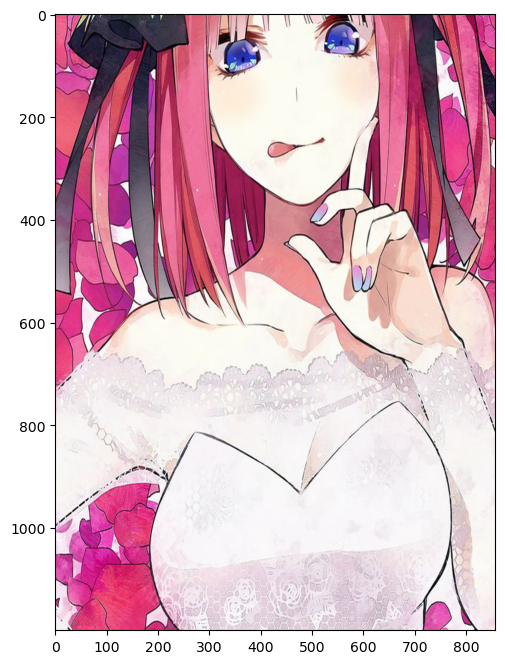

In [16]:
plot_image(RandomCrop(1, crop_scale=(0.4, 0.7), sides_ratio=(1, 1), resize=True)(nino), (6, 8))

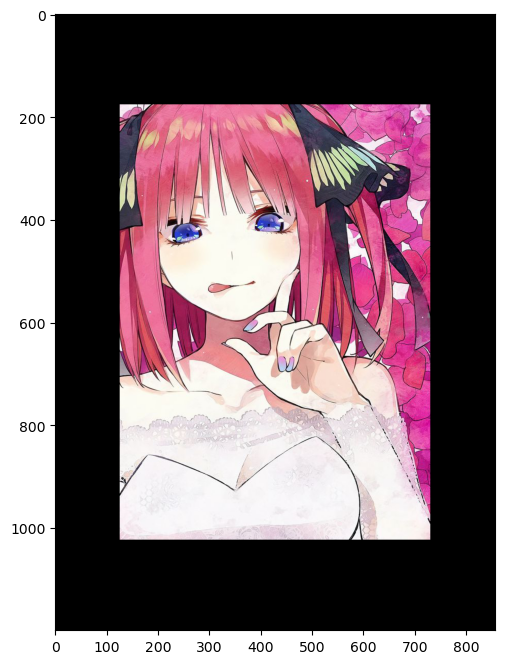

In [17]:
plot_image(RandomCrop(1, crop_scale=0.5, pad_resize=True)(nino), (6, 8))

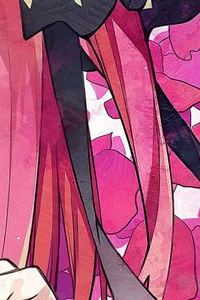

In [18]:
# plot_image(RandomCrop(1, size=(200, 300), resize=False)(nino), (6, 8))
RandomCrop(1, size=(200, 300), resize=False)(nino)

### RandomRotate

In [19]:
class RandomRotate(BaseTransform):

    def __init__(
            self,
            p: float = 0.5,
            angles: float | tuple[float, float] | None = None,
            resample: int = Image.Resampling.BICUBIC,
            expand: bool = False,
            center: tuple[float, float] | None = None,
            translate: tuple[int, int] | None = None,
            fillcolor: float | tuple[float, ...] | str | None = None
    ) -> None:
        super(RandomRotate, self).__init__(p)
        self.angles = angles
        self.resample = resample
        self.expand = expand
        self.center = center
        self.translate = translate
        self.fillcolor = fillcolor

    def apply(self, img: Image.Image) -> Image.Image:
        if self.angles is None:
            angle = self._rng.uniform(0, 360)
        elif isinstance(self.angles, (float, int)):
            if self.angles < 0:
                self.angles = abs(self.angles)
            angle = self._rng.uniform(-self.angles, self.angles)
        elif isinstance(self.angles, tuple):
            angle = self._rng.uniform(self.angles[0], self.angles[1])

        params = {key: value for key, value in self.__dict__.items() 
                  if key not in ['p', '_rng']}
        params.pop('angles')
        params['angle'] = angle

        return img.rotate(**params)

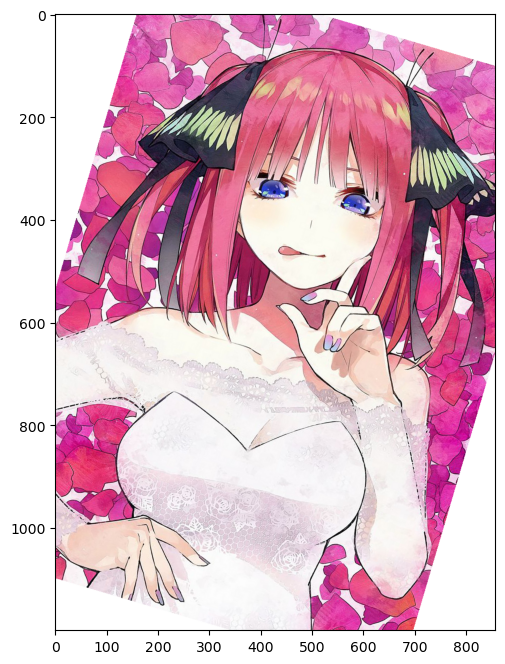

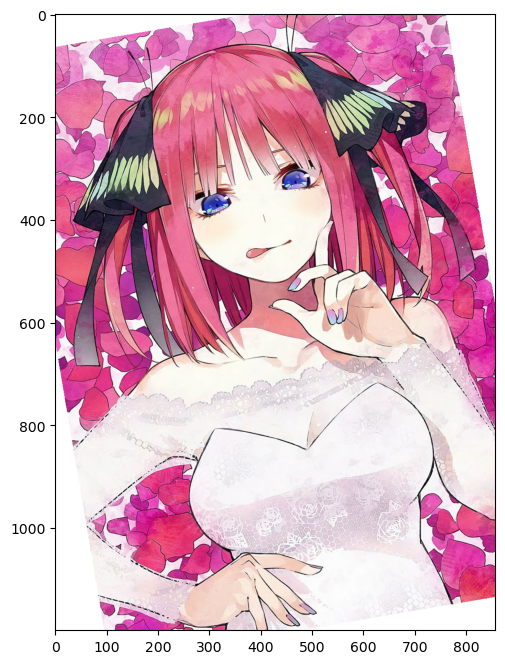

In [20]:
tmp = RandomRotate(1, 40, fillcolor=(255,255,255))
plot_image(tmp(nino), (6, 8))
plot_image(tmp(nino), (6, 8))

### RandomZoom

[Pytorch RandomZoomOut](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomZoomOut.html#torchvision.transforms.v2.RandomZoomOut)

In [21]:
class RandomZoom(BaseTransform):

    def __init__(
            self, p: float, 
            zoom_factor: float | tuple[float, float] | None = None,
            zoom_point: tuple[float, float] | None = None
    ) -> None:
        super().__init__(p)
        self.zoom_factor = zoom_factor
        # zoom_point in current implementation is used only in case of zooming in
        self.zoom_point = zoom_point

    def apply(self, img: Image.Image) -> Image.Image:
        if self.zoom_factor is None:
            zoom_factor = self._rng.uniform(0.3, 3)
        elif isinstance(self.zoom_factor, (int, float)):
            zoom_factor = self.zoom_factor
        elif isinstance(self.zoom_factor, tuple):
            zoom_factor = self._rng.uniform(self.zoom_factor[0], self.zoom_factor[1])

        width, height = img.size

        if zoom_factor < 1.0:

            new_width = np.floor(width * zoom_factor).astype(int)
            new_height = np.floor(height * zoom_factor).astype(int)

            img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

            pad_width = width - new_width
            pad_height = height - new_height

            pad_left = self._rng.integers(0, pad_width)
            pad_right = pad_width - pad_left
            pad_top = self._rng.integers(0, pad_height)
            pad_bottom = pad_height - pad_top

            img = ImageOps.expand(img, (pad_left, pad_top, pad_right, pad_bottom), fill=0)
            
        elif zoom_factor > 1.0:

            new_width = np.floor(width / zoom_factor).astype(int)
            new_height = np.floor(height / zoom_factor).astype(int)

            if self.zoom_point is None:
                # zoom_x, zoom_y = (width // 2, height // 2) # середина изображения
                zoom_x = self._rng.integers(0, width - new_width)
                zoom_y = self._rng.integers(0, height - new_height)
            else:
                zoom_x = min(self.zoom_point[0], width - new_width)
                zoom_y = min(self.zoom_point[1], height - new_height)

            left = zoom_x
            right = left + new_width
            top = zoom_y
            bottom = top + new_height

            img = img.crop((left, top, right, bottom))
            img = img.resize((width, height), Image.Resampling.LANCZOS)

        return img

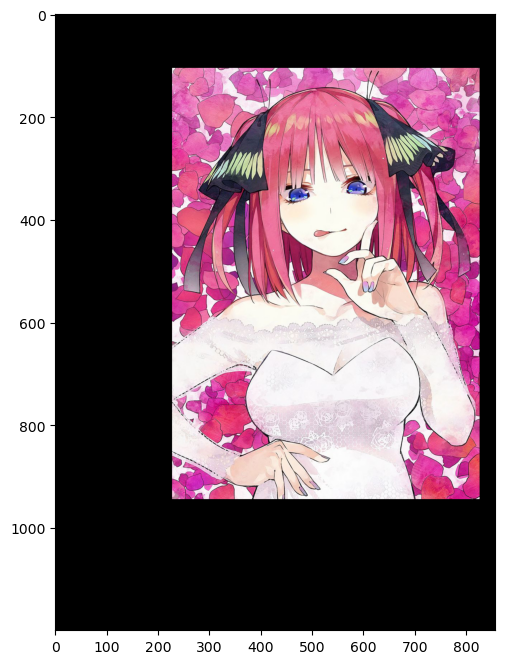

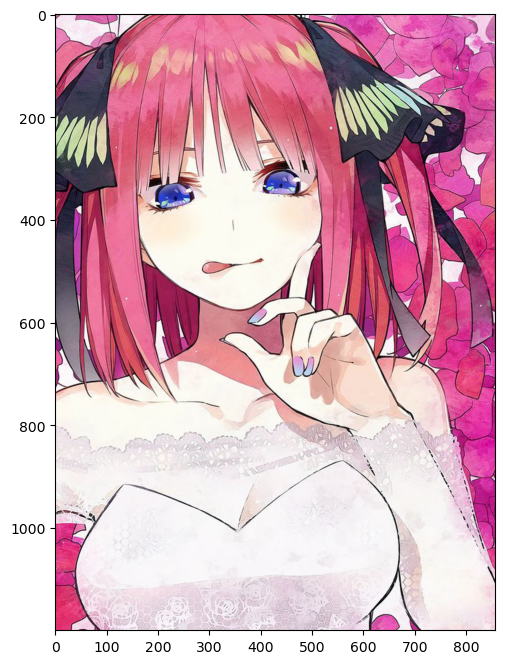

In [22]:
plot_image(RandomZoom(1, 0.7)(nino), (6, 8))
plot_image(RandomZoom(1, 1.3)(nino), (6, 8))

### ToTensor

In [227]:
class ToTensor:
    def __init__(self, scale: bool = False, dtype: Literal['preserve'] | torch.dtype = None) -> None:
        self.scale = scale
        self.dtype = dtype

    def __call__(self, img: Image.Image) -> torch.Tensor:
        img_array = np.array(img)
        
        if self.dtype is None:
            img_tensor = torch.FloatTensor(img_array)
        elif self.dtype == 'preserve':
            img_tensor = torch.from_numpy(img_array)
        elif isinstance(self.dtype, torch.dtype):
            img_tensor = torch.tensor(img_array, dtype=self.dtype)

        if len(img_array.shape) == 3:
            # color channel exists
            img_tensor = img_tensor.permute(2, 0, 1)
        elif len(img_array.shape) == 2:
            # Grayscale
            img_tensor.unsqueeze_(0)

        if self.scale:
            img_tensor /= 255.0
        return img_tensor

In [209]:
ToTensor()(nino).shape

torch.Size([3, 1200, 857])

In [210]:
ToTensor()(nino.split()[0]).shape

torch.Size([1, 1200, 857])

### Normilize

In [77]:
class Normalize:
    def __init__(self, mean: tuple[float, ...], std: tuple[float, ...]):
        self.mean = mean
        self.std = std

    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        # img should be a tensor in CxHxW format (channels first)
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input should be a torch.Tensor")
        
        # Normalize each channel
        for i in range(img.shape[0]):  # Assuming img has shape (C, H, W)
            img[i] = (img[i] - self.mean[i]) / self.std[i]
        
        return img

In [78]:
nino_my_t = ToTensor()(nino)
nino_mean, nino_std = nino_my_t.mean(dim=(1, 2)), nino_my_t.std(dim=(1, 2))
nino_mean, nino_std

(tensor([213.3752, 152.8424, 178.8067]), tensor([53.9756, 80.9118, 61.1539]))

In [79]:
tmp = Normalize(mean=nino_mean, std=nino_std)(ToTensor()(nino))
tmp[0][400][600:610]

tensor([0.2524, 0.3451, 0.4192, 0.3821, 0.2895, 0.1968, 0.1042, 0.0857, 0.2339,
        0.1783])

### Compose

#### !!! RandomResizeCrop - то же самое, что и RandomZoom при приближении, а без ресайза смысла в этом нет, если не делать паддинг

In [80]:
class Compose(BaseTransform):
    def __init__(self, transforms: list[BaseTransform]):
        super(Compose, self).__init__(1)
        self.transforms = transforms

    def apply(self, img: Image.Image) -> torch.Tensor:
        for transform in self.transforms:
            img = transform(img)
        return img

In [81]:
transforms = Compose([
        RandomCrop(p=1),
        RandomRotate(p=1),
        RandomZoom(p=1),
        ToTensor()
    ])

In [82]:
compose_result = transforms(nino)
compose_result.shape

torch.Size([3, 710, 507])

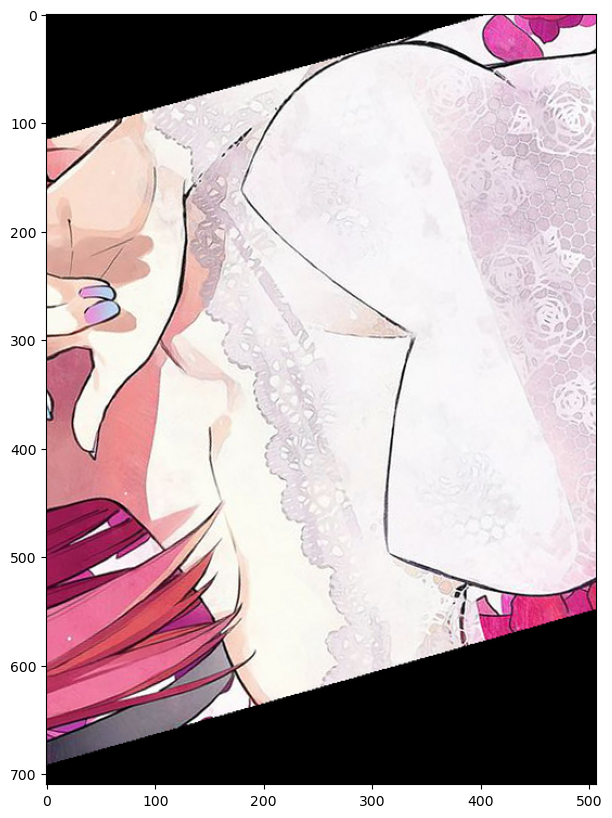

In [83]:
plt.figure(figsize=(8, 10))
plt.imshow(compose_result.permute(1,2,0).type(torch.int32))
plt.show()

# v2.ToPILImage()(nino_t_noisy)

---

---

## Task 4

Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2. В этом задании можно пользоваться torch.nn, за исключением трансформаций. Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций. Проведите обучение на большом количестве эпох. Опишите, что вы наблюдаете для каждого случая и какая есть разница, если применить трансформации. Предоставьте графики в matplotlib или tensorboard (+1 балл) в ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

### Baseline пример без аугментаций

In [194]:
# # Более простая модель
# class BaselineCNN(nn.Module):

#     def __init__(self, in_shape: int, hidden_units: int, out_shape: int):
#         super(BaselineCNN, self).__init__()
        
#         self.conv_1 = nn.Sequential(
#             nn.Conv2d(in_channels=in_shape,
#                       out_channels=hidden_units,
#                       kernel_size=3,
#                       stride=1,
#                       padding=1),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=hidden_units,
#                       out_channels=hidden_units,
#                       kernel_size=3,
#                       stride=1,
#                       padding=1),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.conv_2 = nn.Sequential(
#             nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
#             nn.LeakyReLU(),
#             nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(2)
#         )

#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=hidden_units*7*7,
#                       out_features=out_shape)
#         )

#     def forward(self, x: torch.Tensor):
#         out = self.conv_1(x)
#         # print(out.shape)
#         out = self.conv_2(out)
#         # print(out.shape)
#         out = self.fc(out)
#         # print(out.shape)
#         return out


In [195]:
# baseline_cnn = BaselineCNN(1, 10, len(train_dataset.classes)).to(device)
# baseline_cnn

---

In [33]:
class BaselineCNN(nn.Module):

    def __init__(self, in_shape: int, out_shape: int):
        super(BaselineCNN, self).__init__()
        
        self.conv_1 = self._make_conv_layer(in_shape, 64, 'same')

        self.conv_2 = self._make_conv_layer(64, 128, 'same')

        self.conv_3 = self._make_conv_layer(128, 256, 'same')

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256,
                      out_features=1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024,
                      out_features=512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512,
                      out_features=out_shape)
        )

        self._initialize_weights('norm')

    def forward(self, x: torch.Tensor):
        out = self.conv_1(x)
        # print(out.shape)
        out = self.conv_2(out)
        # print(out.shape)
        out = self.conv_3(out)
        # print(out.shape)
        out = self.fc(out)
        # print(out.shape)
        return out
    
    def _make_conv_layer(self, in_channels, out_channels, padding, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=stride,
                      padding=padding), # 'same'
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
    
    def _initialize_weights(self, init_distr: Literal['no', 'norm', 'uniform']):
        # Почему нельзя применить инициализацию для bias?
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                # print('init applied to ', m)
                if init_distr == 'uniform':
                    nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                elif init_distr == 'norm':
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

In [221]:
baseline_cnn = BaselineCNN(1, 10).to(device)

In [222]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(baseline_cnn.parameters(), lr=0.001)

In [ ]:
next(iter(train_loader))

In [ ]:
train_model(baseline_cnn, train_loader, criterion, optimizer, device=device)

In [ ]:
evaluate_model(baseline_cnn, test_loader, device)

---

#### Аугментация

In [384]:
train_dataset = torchvision.datasets.FashionMNIST(root='./datasets', 
                                           train=True, 
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./datasets', 
                                          train=False,
                                          transform=ToTensor(scale=True))

train_dataset.data.size(), train_dataset.targets.size(), type(train_dataset[0][0]), test_dataset[0][0].type()

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 PIL.Image.Image,
 'torch.FloatTensor')

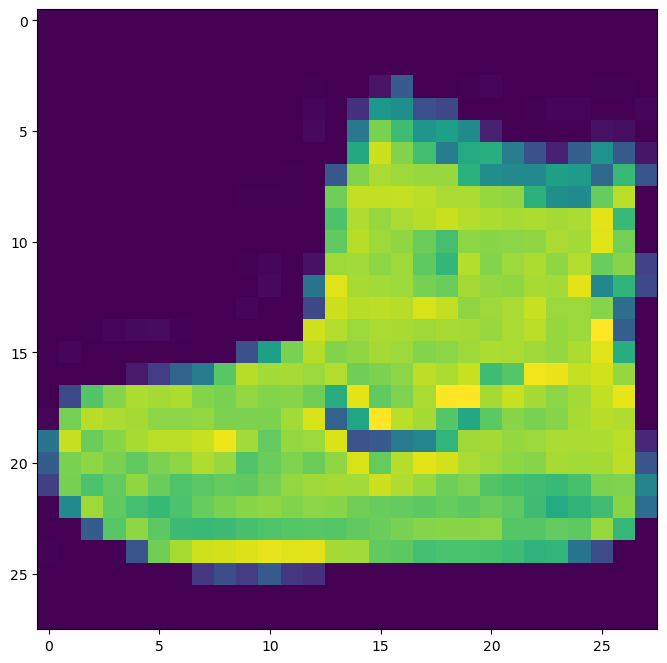

In [385]:
plt.figure(figsize=(8, 10))
plt.imshow(train_dataset[0][0])
plt.show()

In [386]:
transforms = Compose([
        RandomCrop(p=1, crop_scale=(0.7, 1.0), resize=True),
        RandomRotate(p=1, angles=30),
        RandomZoom(p=1, zoom_factor=(1.0, 1.3)),
        ToTensor(scale=True)
    ])

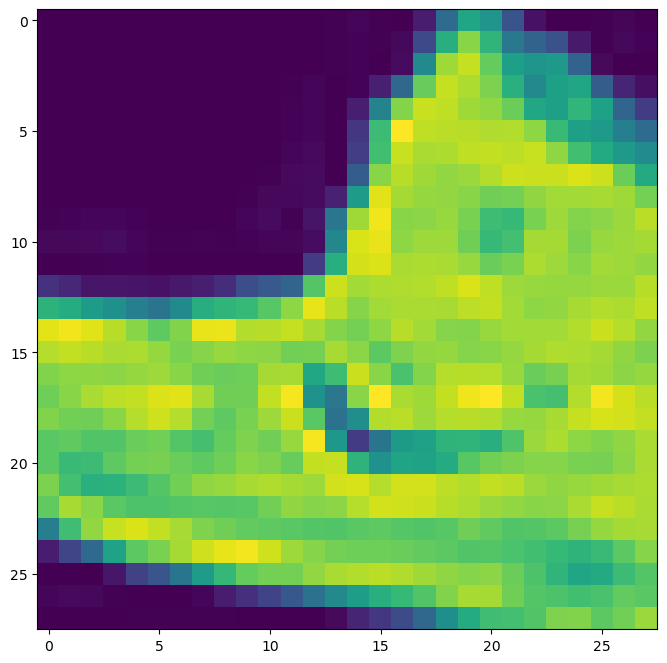

In [387]:
plt.figure(figsize=(8, 10))
plt.imshow(transforms(train_dataset[0][0]).squeeze())
plt.show()

In [388]:
# Пока RandomCrop все еще работает как приближение в RandomZoom. Надо попробовать
# модифицировать его, чтобы он был похож на pytorch-евскую версию функции.
# Если убрать resize, то частично это уже правда. Осталось только реализовать функционал,
# когда размер желаемого кропа больше, чем размер исходного изображения.
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.transforms = Compose([
            RandomCrop(p=0.5, crop_scale=(0.7, 1.0), resize=True),
            RandomRotate(p=0.5, angles=30),
            RandomZoom(p=0.5, zoom_factor=(0.7, 1.3)),
            ToTensor(scale=True)
        ])

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        image = self.transforms(image)
        return image, label

In [389]:
train_dataset = AugmentedDataset(train_dataset)

In [390]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

tmp_train, tmp_test = next(iter(train_loader)), next(iter(test_loader))
print(tmp_train[0].shape, tmp_train[0][0][0][14], tmp_train[0].type())
print(tmp_test[0].shape, tmp_test[0][0][0][14], tmp_test[0].type())

torch.Size([32, 1, 28, 28]) tensor([0.0000, 0.0000, 0.0039, 0.0157, 0.0235, 0.0275, 0.0078, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.9294, 0.8863, 0.8510, 0.8745, 0.8706, 0.8588,
        0.8706, 0.8667, 0.8471, 0.8745, 0.8980, 0.8431, 0.8549, 1.0000, 0.3020,
        0.0000]) torch.FloatTensor
torch.Size([32, 1, 28, 28]) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0157, 0.0039,
        0.0000, 0.0000, 0.0000, 0.3843, 0.5333, 0.4314, 0.4275, 0.4314, 0.6353,
        0.5294, 0.5647, 0.5843, 0.6235, 0.6549, 0.5647, 0.6196, 0.6627, 0.4667,
        0.0000]) torch.FloatTensor


In [391]:
augmented_cnn = BaselineCNN(1, 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(augmented_cnn.parameters(), lr=0.001)

In [392]:
train_model(augmented_cnn, train_loader, criterion, optimizer, device=device)

Epoch 1/5, Loss: 0.7774748542308807
Epoch 2/5, Loss: 0.4828496729969978
Epoch 3/5, Loss: 0.4296871001402537
Epoch 4/5, Loss: 0.393163519146045
Epoch 5/5, Loss: 0.3676918120265007


In [393]:
evaluate_model(augmented_cnn, test_loader, device)

Accuracy: 89.02%


---

Pytorch Compose

In [376]:
train_dataset = torchvision.datasets.FashionMNIST(root='./datasets', 
                                           train=True, 
                                           download=True)

In [377]:
class AugmentedDatasetPytorch(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.transforms = v2.Compose([
        v2.RandomApply([
            v2.RandomResizedCrop(size=28, scale=(0.7, 1.0), ratio=(1.0, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
            v2.RandomRotation(degrees=30),
            v2.RandomZoomOut(side_range=(1.0, 1.3))
        ], p=1.0),
        v2.Resize((28, 28)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ])

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        image = self.transforms(image)
        return image, label

In [378]:
train_dataset_p = AugmentedDatasetPytorch(train_dataset)
train_loader = DataLoader(train_dataset_p, batch_size=32, num_workers=0)

In [379]:
train_loader = DataLoader(train_dataset_p, batch_size=32, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

tmp_train, tmp_test = next(iter(train_loader)), next(iter(test_loader))
print(tmp_train[0].shape, tmp_train[0][0][0][14], tmp_train[0].type())
print(tmp_test[0].shape, tmp_test[0][0][0][14], tmp_test[0].type())

torch.Size([32, 1, 28, 28]) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0039, 0.0078, 0.0039, 0.0627, 0.7922, 0.8902, 0.8510, 0.8588, 0.8627,
        0.8510, 0.8471, 0.8863, 0.8667, 0.7686, 0.8275, 0.8941, 0.8745, 0.8784,
        0.0824]) torch.FloatTensor
torch.Size([32, 1, 28, 28]) tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0157, 0.0039,
        0.0000, 0.0000, 0.0000, 0.3843, 0.5333, 0.4314, 0.4275, 0.4314, 0.6353,
        0.5294, 0.5647, 0.5843, 0.6235, 0.6549, 0.5647, 0.6196, 0.6627, 0.4667,
        0.0000]) torch.FloatTensor


In [381]:
augmented_cnn = BaselineCNN(1, 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(augmented_cnn.parameters(), lr=0.001)

In [382]:
train_model(augmented_cnn, train_loader, criterion, optimizer, device=device)

Epoch 1/5, Loss: 0.8038619240363439
Epoch 2/5, Loss: 0.5156496804475784
Epoch 3/5, Loss: 0.4548243010520935
Epoch 4/5, Loss: 0.41617595511277516
Epoch 5/5, Loss: 0.3904464357773463


In [383]:
evaluate_model(augmented_cnn, test_loader, device)

Accuracy: 87.48%
